
=== DESCRIPTIVE STATISTICS (NUMERIC) ===

                 count         mean          std    min       25%       50%  \
tenure          7032.0    32.421786    24.545260   1.00    9.0000    29.000   
MonthlyCharges  7032.0    64.798208    30.085974  18.25   35.5875    70.350   
TotalCharges    7032.0  2283.300441  2266.771362  18.80  401.4500  1397.475   

                      75%      max  
tenure            55.0000    72.00  
MonthlyCharges    89.8625   118.75  
TotalCharges    3794.7375  8684.80  


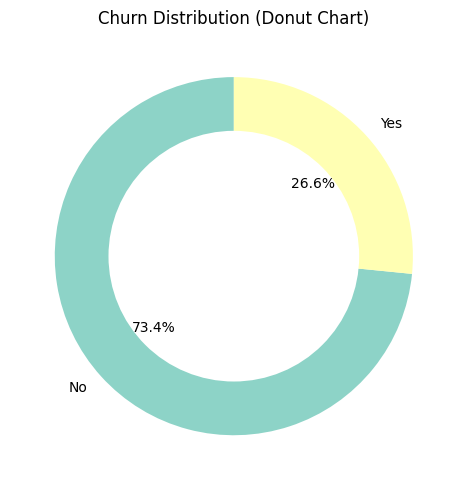

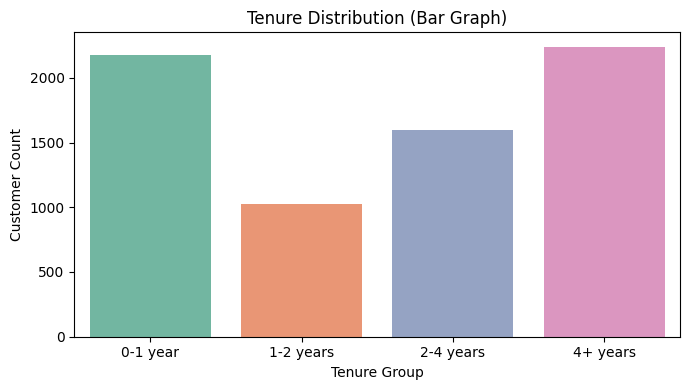

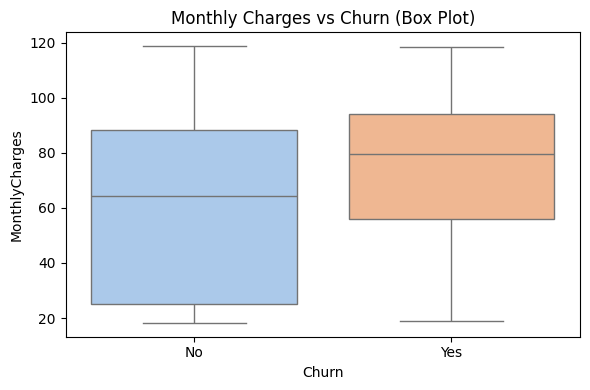

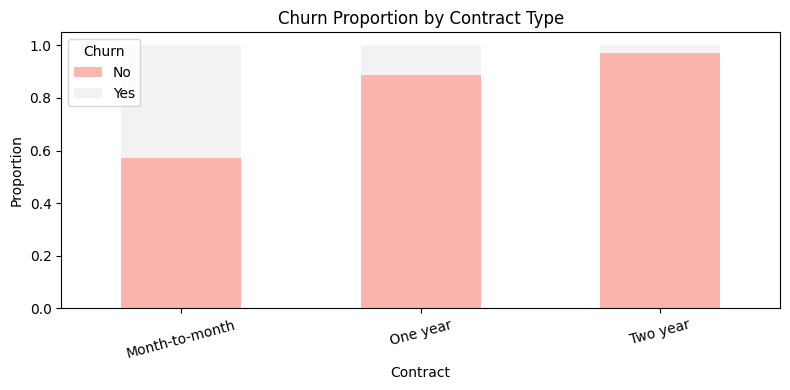


Saved processed dataset to data/processed/telco_processed.csv


In [6]:

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
sns.set_palette(["green"])

DATA_PATH = "Telco-Customer-Churn.csv"

def load_and_clean(path=DATA_PATH):
    df = pd.read_csv(path)
    # replace empty strings with NaN and convert TotalCharges to numeric
    df.replace(" ", np.nan, inplace=True)
    df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
    df.dropna(subset=["TotalCharges"], inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

def feature_engineer(df):
    # Derived features
    service_features = ["OnlineSecurity", "OnlineBackup", "DeviceProtection",
                        "TechSupport", "StreamingTV", "StreamingMovies"]
    df["num_services"] = df[service_features].apply(lambda x: (x == "Yes").sum(), axis=1)
    df["avg_charge_per_month"] = df["TotalCharges"] / df["tenure"].replace(0, 1)
    df["tenure_bucket"] = pd.cut(df["tenure"],
                                 bins=[-1,12,24,48,df["tenure"].max()],
                                 labels=["0-1 year","1-2 years","2-4 years","4+ years"])
    # Ensure Churn is binary mapping
    df["Churn_flag"] = df["Churn"].map({"Yes":1, "No":0})
    return df

def descriptive_stats(df):
    print("\n=== DESCRIPTIVE STATISTICS (NUMERIC) ===\n")
    print(df[["tenure", "MonthlyCharges", "TotalCharges"]].describe().T)
def eda_plots(df, show=True, save_dir="outputs/figures"):
    os.makedirs(save_dir, exist_ok=True)


    # 1. CHURN DISTRIBUTION


    # Donut Chart
    churn_counts = df["Churn"].value_counts()
    plt.figure(figsize=(5,5))
    plt.pie(churn_counts, labels=churn_counts.index,
            autopct="%1.1f%%", startangle=90,
            colors=sns.color_palette("Set3"))
    centre_circle = plt.Circle((0,0),0.70,fc="white")
    plt.gca().add_artist(centre_circle)
    plt.title("Churn Distribution (Donut Chart)")
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "churn_donut.png"))
    if show: plt.show()
    plt.close()

    # 2. TENURE DISTRIBUTION

    # Vertical Bar Graph (Tenure Buckets)
    plt.figure(figsize=(7,4))
    sns.countplot(x="tenure_bucket", data=df, palette="Set2")
    plt.title("Tenure Distribution (Bar Graph)")
    plt.xlabel("Tenure Group")
    plt.ylabel("Customer Count")
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "tenure_bar.png"))
    if show: plt.show()
    plt.close()

    # 3. MONTHLY CHARGES vs CHURN


    #  Box Plot
    plt.figure(figsize=(6,4))
    sns.boxplot(x="Churn", y="MonthlyCharges", data=df, palette="pastel")
    plt.title("Monthly Charges vs Churn (Box Plot)")
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "monthlycharges_box.png"))
    if show: plt.show()
    plt.close()


    # 4. CHURN BY CONTRACT TYPE

    # Stacked Bar Chart (Proportion)
    contract_churn = pd.crosstab(df["Contract"], df["Churn"], normalize="index")
    contract_churn.plot(kind="bar", stacked=True, figsize=(8,4),
                         colormap="Pastel1")
    plt.title("Churn Proportion by Contract Type")
    plt.ylabel("Proportion")
    plt.xticks(rotation=15)
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "contract_churn_stacked.png"))
    if show: plt.show()
    plt.close()


def main():
    df = load_and_clean()
    df = feature_engineer(df)
    descriptive_stats(df)
    eda_plots(df)
    # Save cleaned dataset for next chapters
    os.makedirs("data/processed", exist_ok=True)
    df.to_csv("data/processed/telco_processed.csv", index=False)
    print("\nSaved processed dataset to data/processed/telco_processed.csv")

if __name__ == "__main__":
    main()



=== Logistic Regression ===
Accuracy: 0.7933649289099526
Precision: 0.6201550387596899
Recall: 0.5714285714285714
F1: 0.5947955390334573
AUC: 0.8322350230414747
Confusion Matrix:
 [[677  98]
 [120 160]]


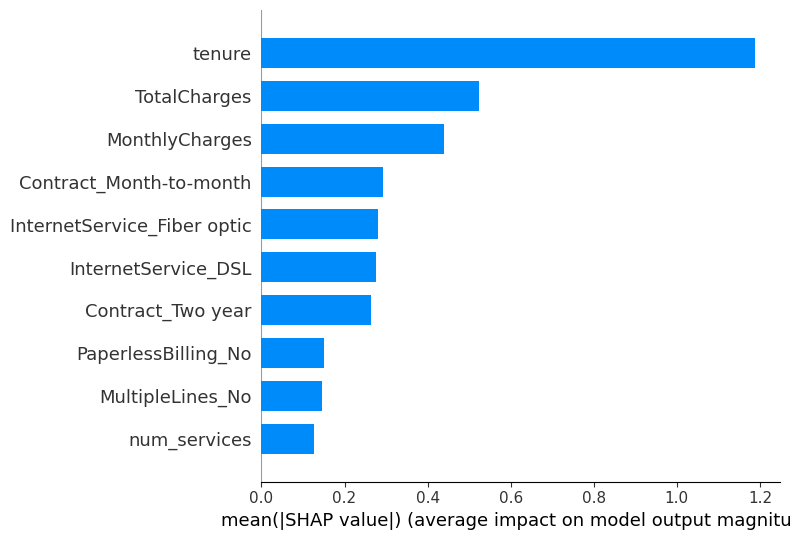

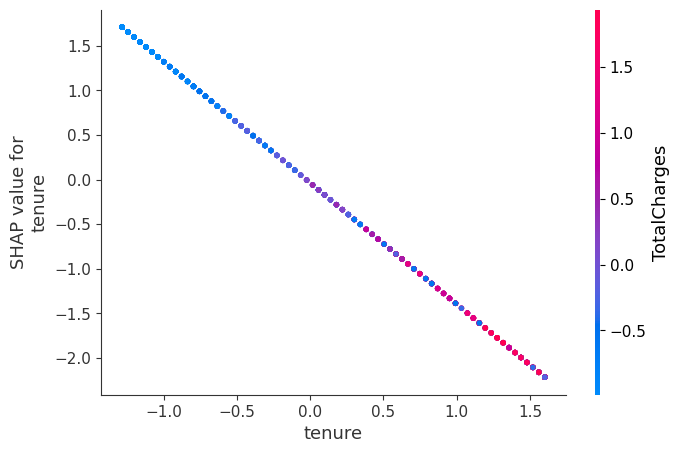


=== Random Forest ===
Accuracy: 0.7848341232227488
Precision: 0.6157205240174672
Recall: 0.5035714285714286
F1: 0.5540275049115914
AUC: 0.8200806451612903

=== XGBoost ===
Accuracy: 0.7668246445497631
Precision: 0.5691056910569106
Recall: 0.5
F1: 0.532319391634981
AUC: 0.8146751152073732


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import shap
import warnings
warnings.filterwarnings("ignore")

# ------------------------------------------------------------
# 1. Load & Clean Data
# ------------------------------------------------------------
df = pd.read_csv("Telco-Customer-Churn.csv")
df.replace(" ", np.nan, inplace=True)
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df.dropna(subset=["TotalCharges"], inplace=True)

# ------------------------------------------------------------
# 2. Feature Engineering
# ------------------------------------------------------------
service_cols = ["OnlineSecurity", "OnlineBackup", "DeviceProtection",
                "TechSupport", "StreamingTV", "StreamingMovies"]

df["num_services"] = df[service_cols].apply(lambda x: (x == "Yes").sum(), axis=1)
df["avg_charge_per_month"] = df["TotalCharges"] / df["tenure"].replace(0, 1)

df["tenure_bucket"] = pd.cut(
    df["tenure"],
    bins=[0, 12, 24, 48, df["tenure"].max()],
    labels=["0-1 year", "1-2 years", "2-4 years", "4+ years"]
)

# ------------------------------------------------------------
# 3. Prepare Data
# ------------------------------------------------------------
X = df.drop(columns=["customerID", "Churn"])
y = df["Churn"].map({"Yes": 1, "No": 0})

num_cols = X.select_dtypes(include=["float64", "int64"]).columns
cat_cols = X.select_dtypes(include=["object"]).columns

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)

# 4. Logistic Regression (Final Model)
lr_model = Pipeline([
    ("prep", preprocessor),
    ("lr", LogisticRegression(max_iter=500))
])

lr_model.fit(X_train, y_train)

lr_pred = lr_model.predict(X_test)
lr_prob = lr_model.predict_proba(X_test)[:, 1]

print("\n=== Logistic Regression ===")
print("Accuracy:", accuracy_score(y_test, lr_pred))
print("Precision:", precision_score(y_test, lr_pred))
print("Recall:", recall_score(y_test, lr_pred))
print("F1:", f1_score(y_test, lr_pred))
print("AUC:", roc_auc_score(y_test, lr_prob))
print("Confusion Matrix:\n", confusion_matrix(y_test, lr_pred))

# ------------------------------------------------------------
# 5. Logistic Regression Feature Importance (SHAP)
# ------------------------------------------------------------
# Get transformed feature names
ohe = lr_model.named_steps["prep"].named_transformers_["cat"]
encoded_feature_names = list(ohe.get_feature_names_out(cat_cols))
all_features = list(num_cols) + encoded_feature_names

# Transform test data
X_test_transformed = lr_model.named_steps['prep'].transform(X_test)

# Use LinearExplainer for Logistic Regression (updated argument for SHAP v0.41+)
explainer = shap.LinearExplainer(
    lr_model.named_steps['lr'],
    X_test_transformed,
    feature_perturbation="interventional"
)
shap_values = explainer.shap_values(X_test_transformed)

# SHAP Summary Bar Plot (Top 10 Features)
shap.summary_plot(shap_values, X_test_transformed, feature_names=all_features, plot_type="bar", max_display=10)

# Optional: Dependence Plot for a Key Feature (e.g., tenure)
shap.dependence_plot("tenure", shap_values, X_test_transformed, feature_names=all_features)

# 6. Random Forest & XGBoost for Comparison

X_train_trans = lr_model.named_steps["prep"].transform(X_train)
X_test_trans = lr_model.named_steps["prep"].transform(X_test)

# Random Forest
rf = RandomForestClassifier(n_estimators=300, random_state=42)
rf.fit(X_train_trans, y_train)
rf_pred = rf.predict(X_test_trans)
rf_prob = rf.predict_proba(X_test_trans)[:, 1]

print("\n=== Random Forest ===")
print("Accuracy:", accuracy_score(y_test, rf_pred))
print("Precision:", precision_score(y_test, rf_pred))
print("Recall:", recall_score(y_test, rf_pred))
print("F1:", f1_score(y_test, rf_pred))
print("AUC:", roc_auc_score(y_test, rf_prob))

# XGBoost
xgb = XGBClassifier(
    n_estimators=300, learning_rate=0.1, max_depth=6,
    subsample=0.9, colsample_bytree=0.9,
    eval_metric="logloss", random_state=42
)
xgb.fit(X_train_trans, y_train)
xgb_pred = xgb.predict(X_test_trans)
xgb_prob = xgb.predict_proba(X_test_trans)[:, 1]

print("\n=== XGBoost ===")
print("Accuracy:", accuracy_score(y_test, xgb_pred))
print("Precision:", precision_score(y_test, xgb_pred))
print("Recall:", recall_score(y_test, xgb_pred))
print("F1:", f1_score(y_test, xgb_pred))
print("AUC:", roc_auc_score(y_test, xgb_prob))


In [3]:
# statistical_tests
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind, chi2_contingency
import os

DATA_CLEAN = "data/processed/telco_processed.csv"

def load():
    df = pd.read_csv(DATA_CLEAN)
    return df

# Independent t-tests (Churn vs Non-Churn)
def t_tests(df):
    churn = df[df["Churn_flag"]==1]
    not_churn = df[df["Churn_flag"]==0]

    numeric_vars = ["tenure", "MonthlyCharges", "TotalCharges", "avg_charge_per_month"]
    print("=== Independent t-tests (Churn vs Non-Churn) ===")
    for col in numeric_vars:
        tstat, pval = ttest_ind(churn[col], not_churn[col], equal_var=False)
        print(f"{col}: t-stat = {tstat:.4f}, p-value = {pval:.4e}")
#Chi-square tests (Categorical)
def chi_square_tests(df):
    categorical_vars = ["Contract", "PaymentMethod", "InternetService", "tenure_bucket"]
    print("\n=== Chi-square tests (Categorical) ===")
    for col in categorical_vars:
        contingency = pd.crosstab(df[col], df["Churn_flag"])
        chi2, p, dof, ex = chi2_contingency(contingency)
        print(f"{col}: chi2 = {chi2:.4f}, p-value = {p:.4e}, dof = {dof}")

def main():
    if not os.path.exists(DATA_CLEAN):
        raise FileNotFoundError(f"{DATA_CLEAN} not found. Run chapter4_data_analysis.py first.")
    df = load()
    t_tests(df)
    chi_square_tests(df)

if __name__ == "__main__":
    main()


=== Independent t-tests (Churn vs Non-Churn) ===
tenure: t-stat = -34.9719, p-value = 2.3471e-234
MonthlyCharges: t-stat = 18.3409, p-value = 2.6574e-72
TotalCharges: t-stat = -18.8008, p-value = 1.1525e-75
avg_charge_per_month: t-stat = 18.1745, p-value = 4.7546e-71

=== Chi-square tests (Categorical) ===
Contract: chi2 = 1179.5458, p-value = 7.3262e-257, dof = 2
PaymentMethod: chi2 = 645.4299, p-value = 1.4263e-139, dof = 3
InternetService: chi2 = 728.6956, p-value = 5.8312e-159, dof = 2
tenure_bucket: chi2 = 864.0200, p-value = 5.6383e-187, dof = 3


In [4]:
import joblib
import os

# Create artifact directory
os.makedirs("data/artifacts", exist_ok=True)

# Extract objects from your pipeline
preprocessor = lr_model.named_steps["prep"]
final_model = lr_model.named_steps["lr"]

# File paths
PREPROCESSOR_PATH = "data/artifacts/preprocessor_logreg.pkl"
MODEL_PATH = "data/artifacts/logistic_regression_model.pkl"

# Save artifacts
joblib.dump(preprocessor, PREPROCESSOR_PATH)
joblib.dump(final_model, MODEL_PATH)

print("✔ Preprocessor saved to:", PREPROCESSOR_PATH)
print("✔ Logistic Regression model saved to:", MODEL_PATH)


✔ Preprocessor saved to: data/artifacts/preprocessor_logreg.pkl
✔ Logistic Regression model saved to: data/artifacts/logistic_regression_model.pkl
